# MAT dSTRF twin experiment

This script runs a twin experiment with a dSTRF model composed of the augmented MAT model and a cosine basis STRF.

In [33]:
from __future__ import print_function, division
import numpy as np
import scipy as sp
import neurofit as nf
import pyspike as pyspk
from scipy.signal import resample

import sys
sys.path.append("../") # for importing utils and glm

import utils
from models import cosstrf, dstrf_mat
import cneurons as cn

from neurofit import utils as nfutils


# plotting packages
%matplotlib inline
from matplotlib.pyplot import * # plotting functions
import seaborn as sns           # data visualization package
sns.set_style("whitegrid")

In [34]:
class mat():
    def __init__(self, free_ts=False,stochastic=False):
        self.nrn = None
        self.free_ts = free_ts
        self.stochastic = stochastic

    def dim(self):
        return 6 if self.free_ts else 4

    def set(self, theta):
        a, b, c, w = theta[:4]
        if self.stochastic:
            self.nrn = cn.augmatsto(a,b,c,w)
        else:
            self.nrn = cn.augmat(a, b, c,w)

        if self.free_ts:
            t1, t2 = theta[4:]
            self.nrn.t1 = t1
            self.nrn.t2 = t2
                
        self.nrn.R = 1
        self.nrn.tm = 1
        
    def run(self, iapp):
        self.nrn.apply_current(iapp, 1)
        return self.nrn.simulate(len(iapp), 1)

## Setting paramters and loading data

In [44]:
# assimilation parameters
nwalkers = 1000
burn = 5000
threads = 8
keep = 1
num_assim_stims = 15
tracker = nfutils.convergence_tracker(burn,burn/10)

# dstrf model settings
free_ts = False
scale = 10
channels = 1
ncos = 15
coslin = 10
norm = True
center = True

# data parameters 
nspec = 30
t_dsample = 5
tlen = int(np.rint(150/t_dsample))
psth_smooth = 5/t_dsample
compress = 1

# setup cosine basis
tbas, fromt, tot = utils.cosbasis(tlen,ncos,coslin,retfn=True,norm=True)

# load data from crcns
cell = "yg0616_4_B"
stim_type = "conspecific"

# load data
model = "phasic-nbs/"

stims,durations,spikes_data,spiky_data = utils.load_rothman(model,nspec,t_dsample,compress)
psth_data = [utils.psth(spk,dur,t_dsample,dsample=t_dsample) for spk,st,dur in zip(spikes_data,stims,durations)]

# separate the simulation and validation sets
assim_psth, test_psth = np.split(psth_data,[num_assim_stims])
assim_spikes, test_spikes = np.split(spikes_data,[num_assim_stims])
assim_spiky, test_spiky = np.split(spiky_data,[num_assim_stims])
assim_stims, test_stims = stims[:num_assim_stims], stims[num_assim_stims:]
assim_dur, test_dur = np.split(durations,[num_assim_stims])

# calculate correlation between even and odd trial psths
eocorr = [utils.evenoddcorr(spks,dur,dsample=t_dsample,smooth=psth_smooth) for spks,dur in zip(spikes_data,durations)]
print("EO: {:.2f}".format(np.mean(eocorr)))

StopIteration: 

## Simulating data for the twin experiment

### Building the STRF

## Getting initial guess for STRF

In [36]:
# estimate STRF using elastic net regression
fit_psth = [nfutils.normalize(p) for p in assim_psth]
#fit_psth = [np.log(p*1000 + 1) for p in assim_psth]

STRF_GUESS, B_GUESS = utils.get_strf(assim_stims,fit_psth,tlen,fit_intercept=False,l1_ratio=[0.1,0.5,0.7,0.9,0.95,1],n_jobs=10)
SPEC,TIM = utils.factorize(STRF_GUESS,1)

# create initial paramter vector from estimated strf
filt_start = np.hstack((SPEC,tot(TIM))).flatten()

0.519605961421


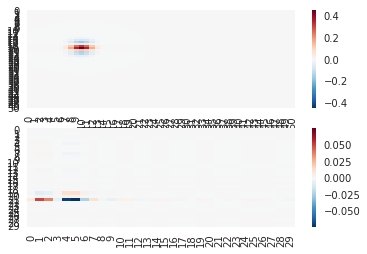

In [37]:
filts = np.load('../filters.npz')
true_filt = filts[model.split("-")[1][:-1]]

# plot true and estimated strf
subplot(211)
sns.heatmap(true_filt)

subplot(212)
strf_model = cosstrf(channels,nspec,tlen,ncos,coslin,normalize=norm,center=center)
strf_model.set(filt_start)
sns.heatmap(strf_model.filt)

print(utils.evaluate(strf_model.filt,test_stims,test_psth))

In [38]:
from neurofit import priors

def spike_distance(predict,data):
    trace, spikes = predict
    spiky = pyspk.SpikeTrain(spikes,[0,data[0].t_end])
    #isi_dist = np.abs(np.mean([pyspk.isi_distance(spiky,trial) for trial in data]))
    dist = np.mean([pyspk.spike_distance(spiky,trial) for trial in data])
    #dist = isi_dist + spike_dist
    return dist*1000

mat_prior = priors.joint_independent(
                [ nf.priors.uniform( -300,300),
                  nf.priors.uniform( -10, 10),
                  nf.priors.uniform( -10, 10),
                  nf.priors.uniform( -30, 30)])

cost = spike_distance
unbounded = priors.unbounded()

def l1_prior(theta):
    return -np.sum(np.abs(theta))

def dstrf_prior(theta):
    return l1_prior(theta[:-4]) + mat_prior(theta[-4:])

## Define loss and prior functions

## Run initial MAT parameter fit

In [39]:
from neurofit import startpos

# get I with STRF fixed
Iapp = []
for s,dur in zip(stims,durations):
    R = resample(strf_model.run(s),dur)
    Iapp.append(R*scale)
    
assim_Iapp, test_Iapp = np.split(Iapp,[num_assim_stims])

# initalize the mat model
mat_model = mat(free_ts=free_ts)

# generate starting positions of emcee walkers
p0 = startpos.uniform_independent(nwalkers,[-300,-10,-10,-10],[300,10,10,10])
#p0 = startpos.normal_independent(nwalkers,[5,0,0,1],[0.1]*4)
#p0 = startpos.normal_independent(nwalkers,matparam,[0.1]*4)

# run emcee
mat_smplr = nf.sampler(mat_model,mat_prior,cost,nwalkers,zip(assim_Iapp,assim_spiky),threads)

for pos,_,_ in tracker(mat_smplr.sample(p0,iterations=burn)): continue
mat_smplr.reset()
mat_smplr.run_mcmc(pos,1);

  step      lnprob        time         ETA
------------------------------------------
   500     -2628.4     0:07:25     1:06:59
  1000     -2623.4     0:14:09     0:56:42
  1500     -2616.4     0:20:55     0:48:52
  2000     -2615.1     0:27:42     0:41:36
  2500     -2614.3     0:34:31     0:34:32
  3000     -2613.5     0:41:19     0:27:34
  3500       -2613     0:48:06     0:20:38
  4000     -2612.5     0:54:56     0:13:45
  4500     -2612.2     1:01:44     0:06:52
  5000     -2612.1     1:08:34     0:00:00
  5001     -2612.1     1:08:35     0:00:00


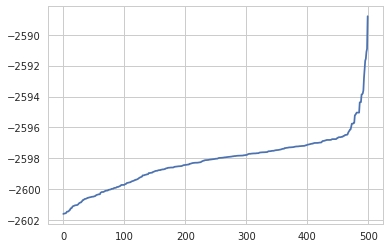

In [40]:
plot(np.sort(mat_smplr.flatlnprobability)[500:])

In [41]:
# check the performance of the fit mat model
mml = mat_smplr.flatchain[np.argmax(mat_smplr.flatlnprobability)]
mat_map = mat()
mat_map.set(mml)
mat_corr = []

param_corr = utils.evaluate(STRF_GUESS,test_stims,test_psth)

for i,p,d in zip(test_Iapp,test_psth,test_dur):
    trace,spikes = mat_map.run(i)
    mat_psth = utils.psth_spiky(pyspk.SpikeTrain(spikes,[0,d]),binres=1,smooth=psth_smooth,dsample=t_dsample)
    mat_corr.append(np.corrcoef(p,mat_psth)[0][1])
        
start = np.hstack((filt_start,mml))
print("Filt R: {:.3f}, MAT R: {:.3f}".format(param_corr,np.mean(mat_corr)))

Filt R: 0.501, MAT R: 0.584


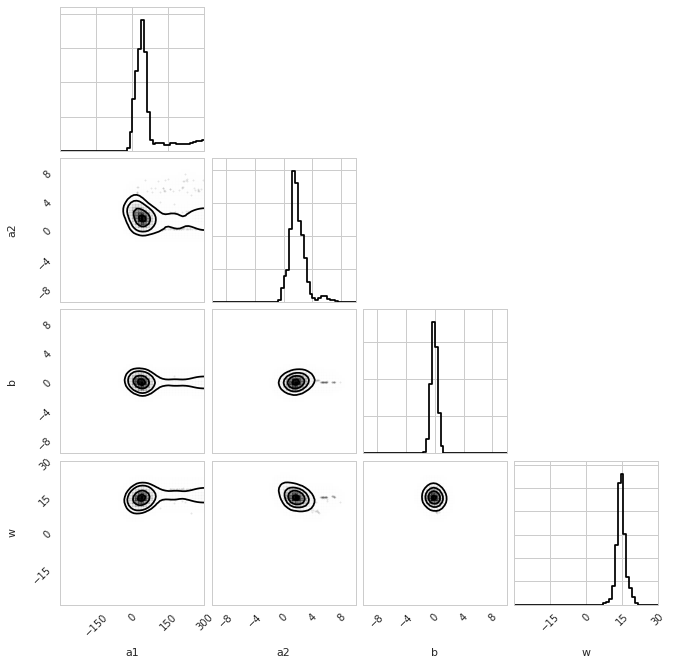

In [42]:
from corner import corner
sns.set_style("whitegrid")

matlabs = ['a1','a2','b','w']
c = corner(mat_smplr.flatchain,
       range=[[-300,300],
              [-10,10],
              [-10,10],
              [-30,30]],
       bins=50, smooth=2,smooth1d=1,
       labels=matlabs)

In [ ]:
mat_smplr.chain[:,0,:].shape

## Fit dSTRF model using emcee

In [ ]:
# initalize the model
model = dstrf_mat(channels,nspec,tlen,ncos,coslin,t_dsample,scale=scale,normalize=norm,center=center)

# set starting positions for walkers
p01 = startpos.normal_independent(nwalkers,filt_start,[1e-1]*len(start))
p02 = mat_smplr.chain[:,0,:]
p0 = np.hstack((p01,p02))

#p0 = startpos.normal_independent(nwalkers-1,start,[1e-4]*len(start))
#p0 = np.vstack((start,p0))

# run emcee
dstrf_smplr = nf.sampler(model,dstrf_prior,spike_distance,nwalkers,zip(assim_stims,assim_spiky),threads)
for pos,_,_ in tracker(dstrf_smplr.sample(p0,iterations=burn)): continue
dstrf_smplr.reset()
dstrf_smplr.run_mcmc(pos,1);

  step      lnprob        time         ETA
------------------------------------------
   500     -3320.6     0:30:30     4:35:14
  1000     -3276.3     0:49:49     3:19:32
  1500     -3261.6     1:08:37     2:40:16


## Evaluate the model fit

In [87]:
# initalize model with MAP parameter estimate
dmap = dstrf_smplr.flatchain[np.argmax(dstrf_smplr.flatlnprobability)]
model.set(dmap)

figure(figsize=(4,4))
# compare true and estimated STRFs
subplot(211)
sns.heatmap(M.pstrf.filt,)

subplot(212)
sns.heatmap(model.pstrf.filt)
tight_layout()

NameError: name 'dstrf_smplr' is not defined

In [86]:
map_corr, map_psths = utils.dstrf_sample_validate(model,dmap,test_stims,test_psth,t_dsample,psth_smooth)
ppcorr, pp_psths = utils.posterior_predict_corr(model,test_stims,test_psth,dstrf_smplr.flatchain,t_dsample,psth_smooth)
corr_means = np.mean([map_corr,ppcorr,eocorr[num_assim_stims:]],axis=1)
print("\nMAP: {:.2f}, Dist: {:.2f}, EO: {:.2f}".format(corr_means[0],corr_means[1],corr_means[2]))
#print("MAP/EO: {:.2f}, Dist/EO: {:.2f}".format(corr_means[0]/corr_means[2],corr_means[1]/corr_means[2]))

NameError: name 'dmap' is not defined

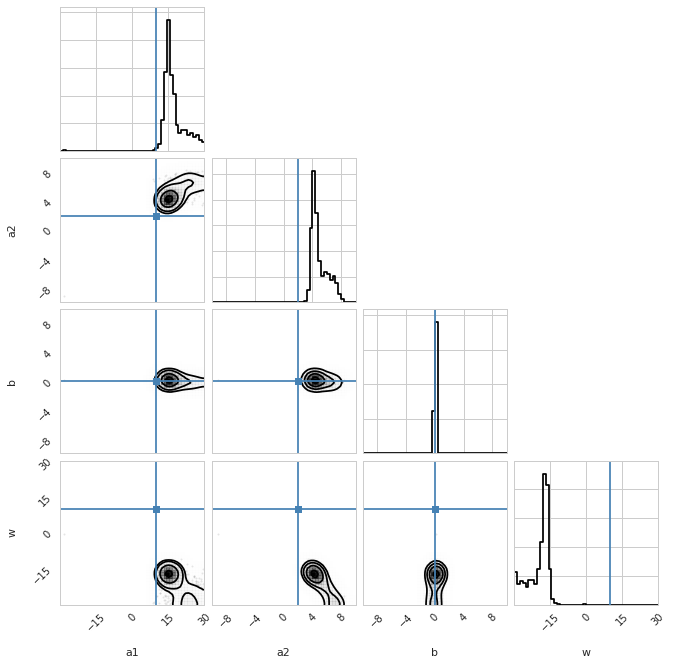

In [152]:
from corner import corner
sns.set_style("whitegrid")

matlabs = ['a1','a2','b','w']
c = corner(dstrf_smplr.flatchain[:,-4:],
       range=[[-30,30],
              [-10,10],
              [-10,10],
              [-30,30]],
       bins=50, smooth=2,smooth1d=0,
       labels=matlabs,
       truths=matparam)